# TensorFlow Probability Interface

In [ ]:
import gpjax
import jax.numpy as jnp
import jax.random as jr
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
from jax import grad, jit

tfd = tfp.distributions
key = jr.PRNGKey(123)
print(gpjax.__version__)

0.3.3


## Simulate some data

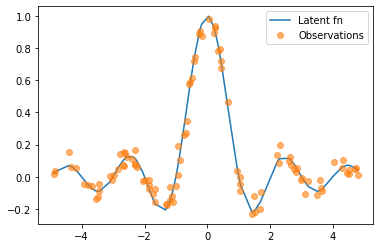

In [ ]:
x = jnp.sort(jr.uniform(key, minval=-5.0, maxval=5.0, shape=(100, 1)), axis=0)
f = lambda x: jnp.sin(jnp.pi * x) / (jnp.pi * x)
y = f(x) + jr.normal(key, shape=x.shape) * 0.05
plt.plot(x, f(x), label="Latent fn")
plt.plot(x, y, "o", label="Observations", alpha=0.6)
plt.legend(loc="best")

## Define GP

In [ ]:
from gpjax import Prior
from gpjax.kernels import RBF
from gpjax.likelihoods import Gaussian

prior = Prior(kernel=RBF())
posterior = prior * Gaussian()
print(posterior)

Conjugate Posterior
--------------------------------------------------------------------------------
- Zero mean function
	 Output dimension: 1
- Radial basis function kernel:
	 Stationary: True
	 Spectral form: False 
	 ARD structure: False
- Gaussian likelihood function


## Initialise parameters

All parameters in this model are constrained to be positive. The softplus transformation will be applied to them to map them onto the entire real line.

In [ ]:
from gpjax.parameters import initialise, build_all_transforms
from gpjax.config import get_defaults

params = initialise(posterior)
configs = get_defaults()
constrainer, unconstrainer = build_all_transforms(params.keys(), configs)
params = unconstrainer(params)

{'lengthscale': DeviceArray([0.54132485], dtype=float64), 'obs_noise': DeviceArray([0.54132485], dtype=float64), 'variance': DeviceArray([0.54132485], dtype=float64)}


## State priors

We'll also place prior distributions on the constrained value of each of our three parameters.

In [ ]:
priors = {
    "lengthscale": tfd.Gamma(1.0, 1.0),
    "variance": tfd.Gamma(2.0, 2.0),
    "obs_noise": tfd.Gamma(2.0, 2.0),
}

## Define target distribution

The marginal log-likelihood distribution can now be computed from the above GP posterior.

In [ ]:
from gpjax.objectives import marginal_ll

mll = marginal_ll(posterior, transform=constrainer, negative=False)

### Check the MLL

In [ ]:
mll(params, x, y, priors)

DeviceArray(-105.28926949, dtype=float64)

In [ ]:
grad(mll)(params, x, y, priors)

{'lengthscale': DeviceArray([1.3475098], dtype=float64),
 'obs_noise': DeviceArray([-29.3289119], dtype=float64),
 'variance': DeviceArray([-2.78458137], dtype=float64)}

## Setup TFP HMC sampler

To allow our MLL function to accept a Jax array as input, not a set of parameters, we'll define a quick helper function to make an arbitary array to our parameter dictionary.

In [ ]:
from typing import List


def array_to_dict(varray: jnp.DeviceArray, keys: List):
    pdict = {}
    for val, key in zip(varray, keys):
        pdict[key] = val
    return pdict

We'll also fix all our marginal log-likelihood's arguments except the parameters input.

In [ ]:
from functools import partial

target_dist = partial(mll, x=x, y=y, priors=priors)

In [ ]:
def build_log_pi(params, target_fn):
    param_keys = list(params.keys())

    def target(params: jnp.DeviceArray):
        coerced_params = array_to_dict(params, param_keys)
        return target_fn(coerced_params)

    return target

In [ ]:
log_pi = build_log_pi(params, target_dist)

So now we have a functional representation of our GP posterior's marginal log-likelihood that accepts a single Jax array as input. It's worthwhile here checking that evaluation of our new function agrees with our initial marginal log-likelihood function.

In [ ]:
initial_params = jnp.array(list(params.values())).squeeze()
print(initial_params)

[0.54132485 0.54132485 0.54132485]


In [ ]:
assert log_pi(initial_params) == mll(params, x, y, priors)

In [ ]:
assert all(grad(log_pi)(initial_params) == jnp.array(list(grad(mll)(params, x, y, priors).values())).squeeze())

With both the marginal log-likelihood and its respective gradient functions in agreeance, we can go ahead and instantiate the TFP HMC sampler.

In [ ]:
def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(log_pi, 1e-1)
    return tfp.mcmc.sample_chain(
        1000,
        current_state=state,
        kernel=kernel,
        trace_fn=lambda _, results: results.target_log_prob,
        seed=key,
    )

In [ ]:
%%time
states, log_probs = jit(run_chain)(key, initial_params)

CPU times: user 9.28 s, sys: 106 ms, total: 9.38 s
Wall time: 9.33 s


The cell above runs much faster than I would expect. However, contrary to the `%%time` function's output, the cell below runs much slower than I would expect (over 30mins). What's going on here...

In [ ]:
from time import time
start=time()

In [ ]:
%%time
states

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


DeviceArray([[ 0.62972628,  0.45466263,  0.36770161],
             [ 0.54588315, -0.03068447,  0.18910682],
             [ 0.67626365, -0.45411678,  0.37432919],
             ...,
             [ 0.04328819, -5.90599453, -2.26193019],
             [ 0.29871134, -6.32470098, -2.0740497 ],
             [ 0.1033614 , -6.26550812, -2.04197829]], dtype=float64)

In [ ]:
print(f"Actual time: {(time() - start)/60: .2f} mins")

Actual time:  29.02 mins


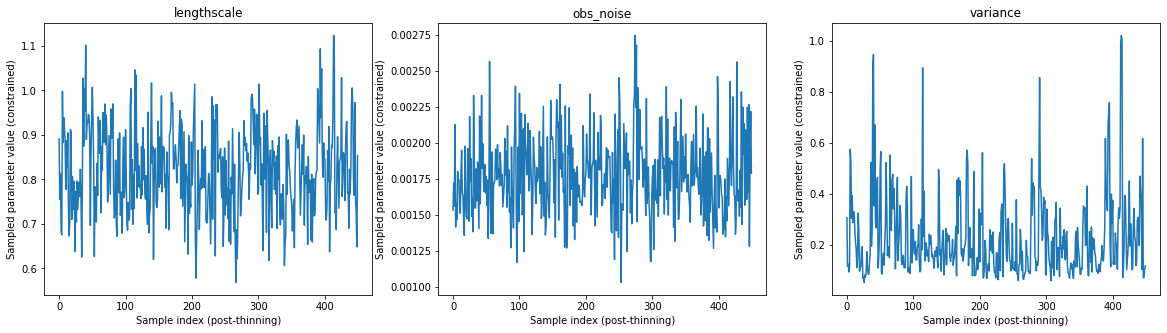

In [ ]:
burn_in = 100
thin_factor = 2
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
ax = ax.ravel()

for a, p, t in zip(ax, states.T, params.keys()):
    a.plot(constrainer(p[burn_in:][::thin_factor]))
    a.set_title(t)
    a.set_xlabel('Sample index (post-thinning)')
    a.set_ylabel('Sampled parameter value (constrained)')